# Data Processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

Loading data using the pandas library:

In [2]:
data = pd.read_csv('input/AB_NYC_2019.csv')
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Now we check the type of data in each column

In [3]:
data.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

## 1.0 Data Cleaning
First, we remove the the features that compromise privacy from our model. In this data, there is only one such feature, and that is the host name. Additionally, this feature is likely irrelevant to the performance of an airbnb unit.

In [4]:
data.drop(['host_name'], axis=1, inplace =True)

Now let's look at what data is missing from our dataset:

In [5]:
data.isnull().sum()

id                                    0
name                                 16
host_id                               0
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

The next step is to modify the 'last_review' column, which is in object format. To make use of this as a feature, I will change the format to numerical using the pandas built in method.

In [6]:
data['last_review'] = pd.to_datetime(data['last_review'],infer_datetime_format=True) 

Since not all samples have a value for last_review, we will fill it with the earliest one.

In [7]:
earliest = min(data['last_review'])
data['last_review'] = data['last_review'].fillna(earliest)
data['last_review'] = data['last_review'].apply(lambda x: x.toordinal() - earliest.toordinal())

Based on the above, we see that only three features have null values: the name, last review, and reviews per month. Since there are only 16 samples with no name, we will remove these samples entirely from our analysis. This is because I believe that the name of a listing can affect how well it does, and I would like to use name as part of the analysis.

In [8]:
data = data[data['name'].notna()]
data.isnull().sum()

id                                    0
name                                  0
host_id                               0
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                           0
reviews_per_month                 10042
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Now we fill the null values of last review and reviews per month with a zero!

In [9]:
data.fillna({'reviews_per_month':0}, inplace=True)
data.isnull().sum()

id                                0
name                              0
host_id                           0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

## 2.0 Data Visualization
It is expected that the neighbourhood and location of the airbnb unit have significant impact on its value and success. Now we will visualize this to confirm. First we look at the distribution of prices based on the 5 neighbourhood groups!

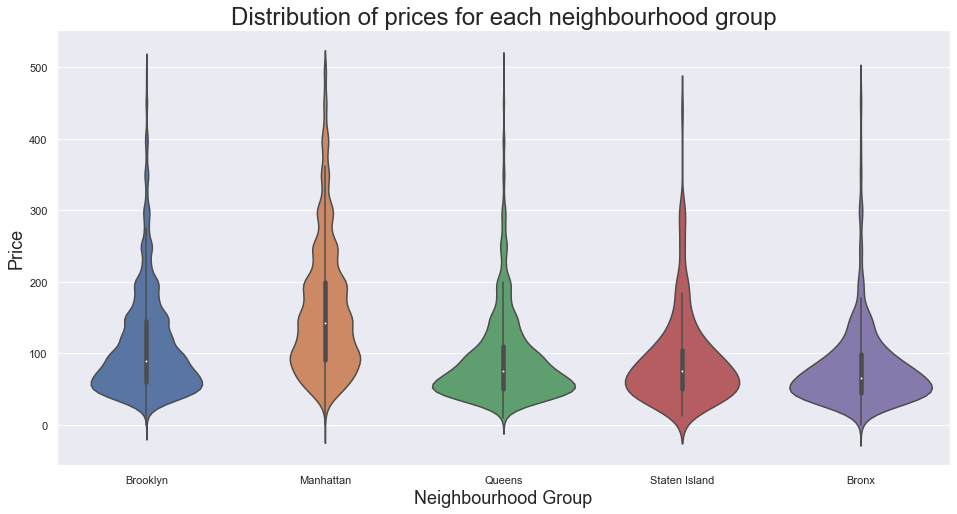

In [10]:
sns.set(font_scale=1)

plt.figure(figsize=(16, 8))
viz1 = sns.violinplot(data=data[data.price < 500], x='neighbourhood_group', y='price')
viz1.set_title('Distribution of prices for each neighbourhood group', fontsize = 24)
viz1.set_xlabel("Neighbourhood Group", fontsize = 18)
viz1.set_ylabel("Price", fontsize = 18)

plt.savefig('output/figures/price_distribution_violin')

Now let's look at a map view of the price distribution over the geographical area of New York City. We do this by overlaying a heatmap of the coordinates and price over a map image of the city, which is provided in the input folder of this project.

No handles with labels found to put in legend.


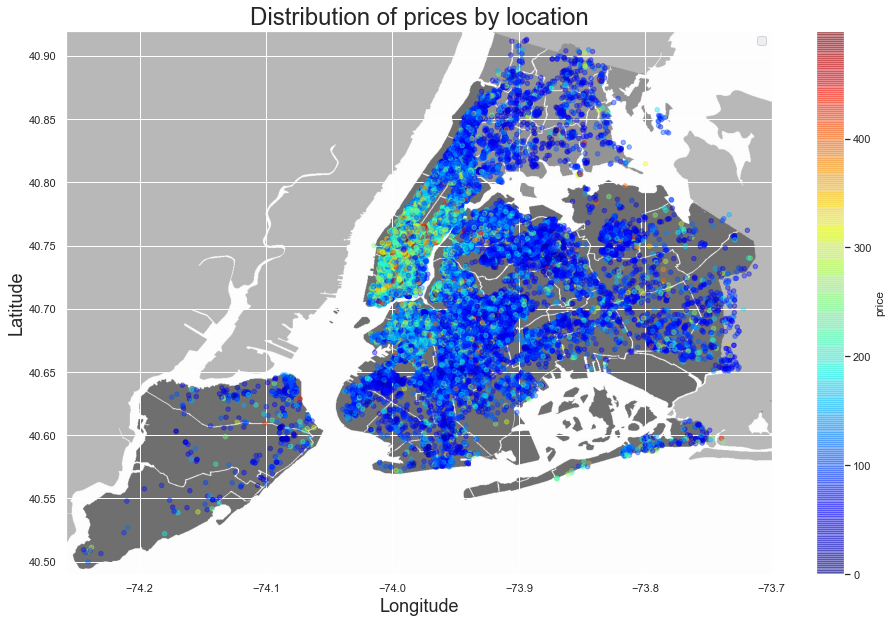

In [11]:
plt.figure(figsize=(16,10))
nyc_img=plt.imread("input/New_York_City.png", 0) #without the 0 we get an "invalid png header" error

#scaling the image based on the latitude and longitude max and mins for proper output
plt.imshow(nyc_img,zorder=0,extent=[-74.258, -73.7, 40.49,40.92])
ax=plt.gca()

#using scatterplot
data[data.price < 500].plot(kind='scatter', x='longitude', y='latitude', c='price', ax=ax, 
           cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, zorder=5)
plt.legend()
plt.title('Distribution of prices by location', fontsize= 24)
plt.xlabel('Longitude', fontsize = 18)
plt.ylabel('Latitude', fontsize = 18)

plt.savefig('output/figures/price_distribution_map')
plt.show()

Now let's look at the distribution of availability over the location. Recall that availability refers to the number of days a year where that unit is not reserved (and is available).

No handles with labels found to put in legend.


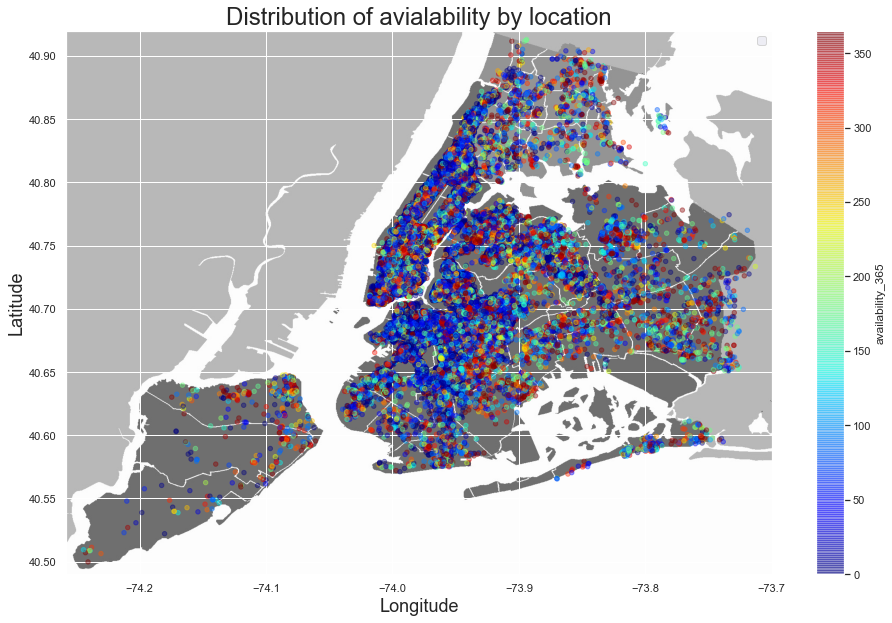

In [12]:
plt.figure(figsize=(16,10))
nyc_img=plt.imread("input/New_York_City.png", 0) #without the 0 we get an "invalid png header" error

#scaling the image based on the latitude and longitude max and mins for proper output
plt.imshow(nyc_img,zorder=0,extent=[-74.258, -73.7, 40.49,40.92])
ax=plt.gca()

#using scatterplot
data[data.availability_365>= 0].plot(kind='scatter', x='longitude', y='latitude', c='availability_365', ax=ax, 
           cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, zorder=5)
plt.legend()
plt.title('Distribution of avialability by location', fontsize=24)
plt.xlabel('Longitude', fontsize = 18)
plt.ylabel('Latitude', fontsize = 18)
plt.savefig('output/figures/availability_distribution_map')
plt.show()

## 3.0 Feature Analysis
Now we will look at the features in our data and attempt to analyze their relevance. This will help determine which features to use in our machine learning model! First, we will look at the correlation of features with each other. For this, we will use the default pearson correlation method.

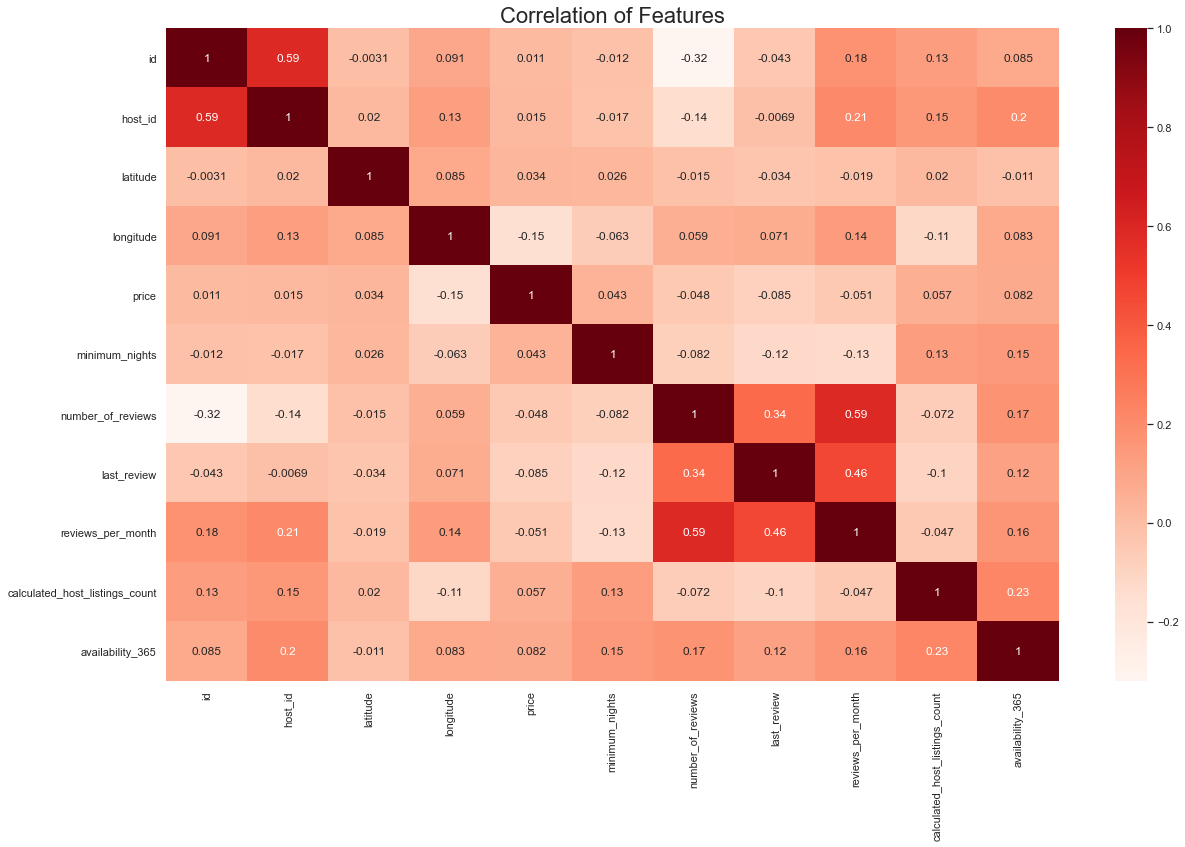

In [13]:
plt.figure(figsize=(20,12))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.title("Correlation of Features", fontsize = 22)
plt.savefig('output/figures/Corr_heatmap')
plt.show()

### 3.1 Price Distribution
The weird distribution of prices in the data can be problematic to machine learning algorithms. This can be visualized below.

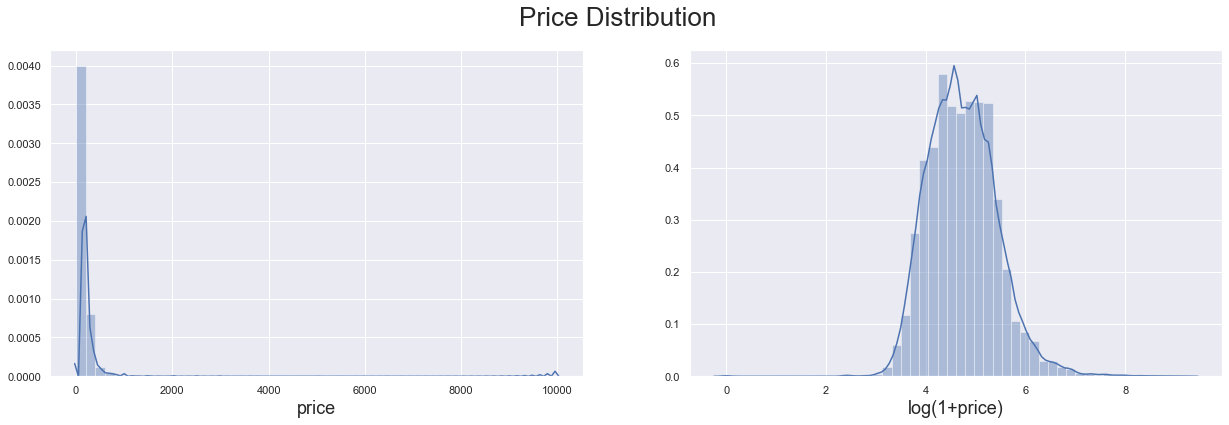

In [19]:
fig, axes = plt.subplots(1,2, figsize=(21,6))
fig.suptitle('Price Distribution', fontsize = 26)
sns.distplot(data['price'], ax=axes[0])
sns.distplot(np.log1p(data['price']), ax=axes[1])
axes[0].set_xlabel('price', fontsize=18)
axes[1].set_xlabel('log(1+price)', fontsize=18)
plt.savefig('output/figures/price_distribution')


As can be seen from above, the log transformation of prices shows a better distribution. We can also see in the new distribution that values in the range of 3 to 8 are the more "reasonable" data. So anything outside that range is likely to do more harm than good. As such, we will remove it:

In [15]:
data = data[np.log1p(data['price']) < 8]
data = data[np.log1p(data['price']) > 3]
data['price'] = np.log1p(data['price'])

Before we continue, it is important that we seperate our data from our label. For this application, I will use price as the label because we are trying to estimate the price of an airbnb unit.

In [39]:
label = data['price'] #we will use the availability is our label of airbnb unit success
X = data.copy()
print(X.columns)

X.drop(['price'], axis=1, inplace =True) #we need to remove the label from our data

features = X.columns
print(X.columns)
print(X.shape)
#Converting both dataframes to numpy arrays for mathematical processing
X = X.to_numpy()
y = label.to_numpy()

print(X.shape)
print(y.shape)
print(X[0])

Index(['id', 'name', 'host_id', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')
Index(['id', 'name', 'host_id', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')
(48768, 14)
(48768, 14)
(48768,)
[2539 'Clean & quiet apt home by the park' 2787 'Brooklyn' 'Kensington'
 40.647490000000005 -73.97237 'Private room' 1 9 2762 0.21 6 365]


### 3.2 Information Gain Ratio
Another useful attribute in feature correlation is the correlation of each feature to the output or label used in the model. We already have the correlation of each feature to the price; this can be found in the last row (or last column) of the above heatmap. But there is something else that is useful in determining the correlation of each feature to the output: the information gain ratio!

The information gain ratio is a ratio of the information gain of each feature to its intrinsic value. The information gain is calculated using the entropy of each feature. This is one of the methods that the decision tree algorithm uses in building the decision tree! The information gain ratio is a value from 0 to 1 indicating the relevance of a feature. An information gain ratio of 1 indicates a feature is 100% correlated with the output and as such, can be solely used to determine the output. Contrarily, an information gain of 0 indicates no relevance to the output whatsoever. In other words, the higher the information gain ratio, the more useful that feature is to determining the output!

So, let's look at the information gain ratio of each feature in our data! First, we will use a library I created (with the help of some research and code from other developers) to calculate the information gain ratio. This library is included in the repository and consists of a single python script with the necessary functions.

In [40]:
from lib import feature_processing as fp

infoGainRatio = []

for i in range(len(X[0])):
    print("{}/{}".format(i+1, len(X[0])))
    
    g2 = fp.info_gain_ratio(X[:,i], y)

    infoGainRatio.append(g2)

1/14
2/14
3/14
4/14
5/14
6/14
7/14
8/14
9/14
10/14
11/14
12/14
13/14
14/14


In [41]:
print(len(infoGainRatio))
print(features.shape)

14
(14,)


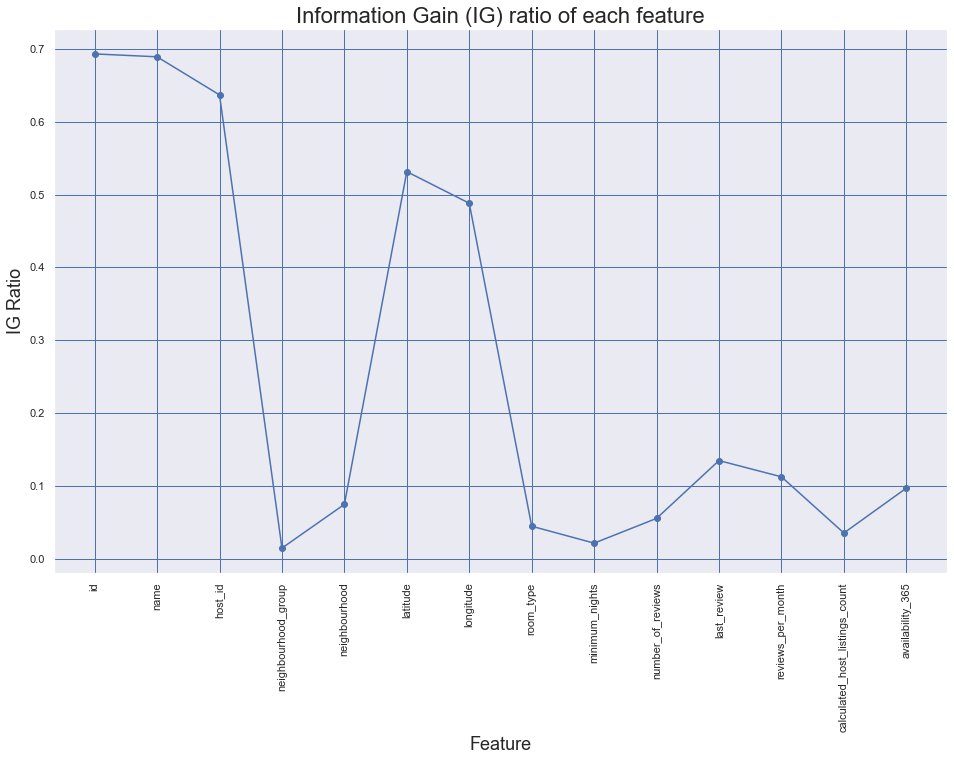

In [42]:
# features = X.columns

plt.figure(figsize=(16,10), facecolor = "w")
plt.scatter(features,infoGainRatio, color = 'b')
plt.plot(features,infoGainRatio, 'b-')

plt.grid(b=True, which='major', color='b', linestyle='-')

plt.ylabel('IG Ratio', fontsize=18)
plt.xlabel('Feature', fontsize=18)
plt.tick_params(axis='x', rotation=90)

plt.title('Information Gain (IG) ratio of each feature', fontsize=22)
plt.savefig('output/figures/IG_ratios')
plt.show()

Both the correlation heatmap and the information gain ratio plot show that id, name, and host_id, are quite relevant to the availability of an airbnb unit. However, we want our model to determine the success of a unit regardless of the identity of the poster. So even if these features show numerical relevance, we will remove them from our data before training the machine learning model!

## 4.0 Feature Engineering
First, we will remove id, name, and host id for the aforementioned reasons.

In [19]:
data.drop(['id', 'name', 'host_id'], axis=1, inplace =True)

Looking at the data type of each remaining feature:

In [20]:
data.dtypes

neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                             float64
minimum_nights                      int64
number_of_reviews                   int64
last_review                         int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

The dataset contains a good number of properties that are available only for a couple of days each year, and a decent number that are available for > 300 days. As such, we will categorize this so the resultant model is not skewed.

In [21]:
data['all_year_avail'] = data['availability_365']>353
data['low_avail'] = data['availability_365']< 12
data['no_reviews'] = data['reviews_per_month']==0
data.drop(['availability_365'], axis=1, inplace =True)

Now let's look at the categorical features. These are the columns with object as the data type

In [22]:
categorical_features = data.select_dtypes(include=['object'])
print('Categorical features: {}'.format(categorical_features.shape))

Categorical features: (48768, 3)


These categorical features have values that belong to a category such as a neighbourhood or room-type. As such, we can convert these to binary features indicating whether each sample belongs to that category. Thankfully, the pandas library makes this really easy!

In [23]:
categorical_features_processed = pd.get_dummies(categorical_features)
categorical_features_processed.head()

,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_Allerton,neighbourhood_Arden Heights,neighbourhood_Arrochar,neighbourhood_Arverne,neighbourhood_Astoria,...,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


We can extract the numerical features in a similar manner:

In [24]:
numerical_features =  data.select_dtypes(exclude=['object'])
print('Numerical features: {}'.format(numerical_features.shape))

Numerical features: (48768, 11)


Now we can combine the newly processed categorical features, with the numerical features:

In [25]:
combined_df = pd.concat([numerical_features, categorical_features_processed], axis=1)
combined_df.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,all_year_avail,low_avail,...,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,40.64749,-73.97237,5.010635,1,9,2762,0.21,6,True,False,...,0,0,0,0,0,0,0,0,1,0
1,40.75362,-73.98377,5.420535,1,45,2976,0.38,2,True,False,...,0,0,0,0,0,0,0,1,0,0
2,40.80902,-73.94190,5.017280,3,0,0,0.00,1,True,False,...,0,0,0,0,0,0,0,0,1,0
3,40.68514,-73.95976,4.499810,1,270,3021,4.64,1,False,False,...,0,0,0,0,0,0,0,1,0,0
4,40.79851,-73.94399,4.394449,10,9,2793,0.10,1,False,True,...,0,0,0,0,0,0,0,1,0,0


Now the data is processed and ready for machine learning models. For the development process of the model, please refer to the model development notebook in this repository.

The last step of the data processing part of the pipeline is to save the newly processed data for convenience:

In [26]:
combined_df.to_csv('input/processed_data_nyc.csv')
numerical_features.to_csv('input/processed_data_nyc_numerical.csv')
categorical_features_processed.to_csv('input/processed_data_nyc_categorical.csv')